<a href="https://colab.research.google.com/github/viniciussantb/dogClassify/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project


 Importing Libraries



In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.8MB/s 
     |████████████████████████████████| 1.2MB 18.5MB/s 
     |████████████████████████████████| 194kB 43.2MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 239kB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

## Download Data



Azure Key - Bing search images


In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '0f3f042355084ec681e1d07a143cb00f')

In [ ]:
search_images_bing

<function fastbook.search_images_bing>

search_images_bing function recieves two arguments:


1.   Azure Key of the project
2.   Content that we want to download



In [ ]:
results = search_images_bing(key, 'labrador')
ims = results.attrgot('contentUrl')
len(ims)

150

In [ ]:
ims

(#150) ['https://vignette.wikia.nocookie.net/thecompletedog/images/3/3e/Black_labrador.jpg/revision/latest?cb=20150112230048','https://embarkvet.com/wp-content/uploads/2018/07/LabradorRetriever.jpg','http://www.fenwaylabradors.co.uk/wp-content/uploads/2019/07/Fenway-Melton-Brian.jpg','http://animalsbreeds.com/wp-content/uploads/2015/03/Labrador-Retriever-3.jpg','http://www.dogwallpapers.net/wallpapers/smiling-labrador-retriver.jpg','https://cdn.fotofits.com/petzlover/gallery/img/l/labrador-634525.jpg','https://cdn.fotofits.com/petzlover/gallery/img/l/labrador-564634.png','https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Labrador-retriever.jpg/1200px-Labrador-retriever.jpg','https://cdn.fotofits.com/petzlover/gallery/img/l/labrador-848884.jpg','http://www.thelabradorsite.com/wp-content/uploads/2016/12/dwarf.jpg'...]

Now that we already have the URLs, we're going to download one image at ```dest``` (destination path of the document) using the download function of fastbook, to see how it goes.






In [ ]:
dest = 'C:\\Users\\vinic\\Documentos\\FinalProjectEN\\exemple.jpg'
download_url(ims[0], dest)

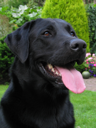

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

Perfect! A pic of a beuty dog.

In [ ]:
dog_types = ['german shepherd', 'bulldog', 'labrador']
path = Path('C:\\Users\\vinic\\Documentos\\FinalProjectEN')

Let's download three different types of dogs at this path for the model training.  

In [ ]:
if not path.exists():
  path.mkdir()
  for dog in dog_types:
    dest = (path/dog)
    dest.mkdir(exist_ok = True)
    results = search_images_bing(key, f'{dog} dog')
    download_images(dest, urls=results.attrgot('contentUrl'))

So this are the images path that we expected.

In [ ]:
files = get_image_files(path)
files

(#0) []

Since we downloaded the images from the internet, there is a high probability that some of our files is corrupt. So let's check and correct.

In [ ]:
failed  = verify_images(files)
failed

(#0) []

In [ ]:
failed.map(Path.unlink);

## DataLoaders

Now we have the data (images) downloaded, we need to turn this data avaliable for the training model. DataLoaderes fuction will solve this problem for us, but first, the datablock API will costumize the stages of creation of the dataloaders.

In [ ]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Let's review the steps that we made in this code:

*   blocks: We pass a tuple containing the independent variable, the type of data that we're using to achieve the target (images). And the type of target that we want (dogs category).
*   get_items: "get_image_files" return a list of path of the images.
*   splitter:  Here, we're setting validation and training set randomly.
*   get_y: "y" is refering to the dependent variable, the parent_label gets the name of the folder that the images are (labrador, german shepherd, bulldog).
*   item_tfms:  Our images don't has the same size, so we resize all of the data.



Now we pass the source of our data creating the the dataloaders.

In [ ]:
dls = dogs.dataloaders(path)

Let's take a look at few of our images.

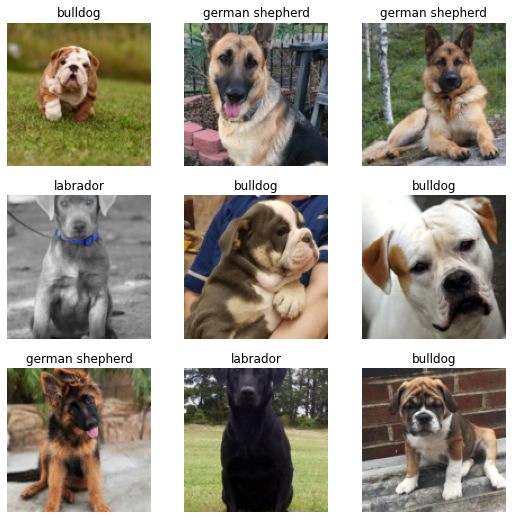

In [ ]:
dls.valid.show_batch()

We resize the images in the item_tmfs variable, we have to becareful because important details could go away. So the fastai help us to squish and stretch them, geting all the details now.

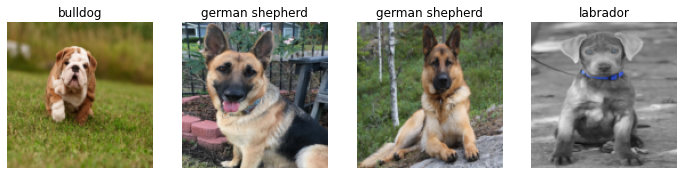

In [ ]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

With all the squish and stretch, we end with a problem! Changing the shape of the images could end with unrealistic dogs, confusing our training model. The deal is to select a random part of the image and crop just that part, so our model learn focus and recognize different features of the image.

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)



> Data Argumentation



Data Argumentation help us creating random variation of the input without changing the meaning of the image, increasing the model accurancy. Flipping, rotation, perspective warping, brightness changes and contrast changes are some of the data argumentation techniques.

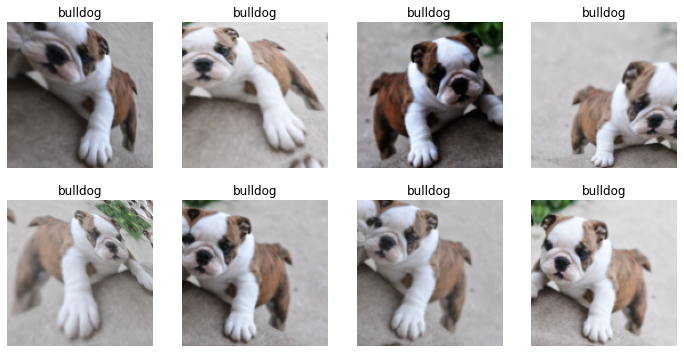

In [ ]:
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

With all this concepts, our data it's ready for the model training!

## Training the Model

We don't have lot of data, so let's use RandomResizeCrop with an image size of 224 px.

In [ ]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

It's time to create our Leaner and fine-tune it!

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Let's see how good our model go with the matrix confunsion.

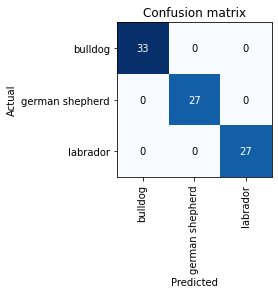

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We can see the images with the top loss in our dataset with plot_top_losses.

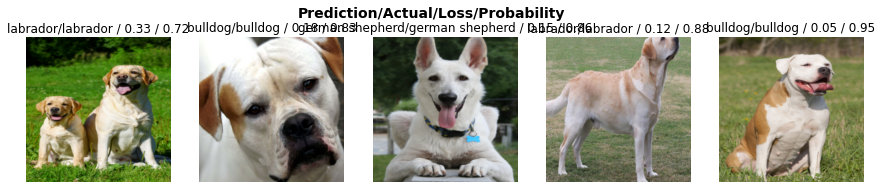

In [ ]:
interp.plot_top_losses(4, nrows=2)

Fastai disposes a GUI to help us see the top highest-loss images and choose removal or relabeling.

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


This line deletes all the images that we want.

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

And this change the category of the selected dogs.

In [ ]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Now that our model it's trained, let's turn into an application!

## Turning the Model into an application

Exporting the model

First of all, let's save our model using the export function.

In [ ]:
learn.export()

In [ ]:
p = Path('C:\\Users\\vinic\\Documentos\\FinalProjectEN\\dog_classifier.pkl')
p.ls

<bound method Path.ls of Path('C:\\Users\\vinic\\Documentos\\FinalProjectEN\\dog_classifier.pkl')>

In [ ]:
learn.export(p)

In [ ]:
p.ls

<bound method Path.ls of Path('C:\\Users\\vinic\\Documentos\\FinalProjectEN\\dog_classifier.pkl')>

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#3) [Path('dogs_classifier.pkl'),Path('C:\\Users\\vinic\\Documentos\\FinalProjectEN\\dog_classifier.pkl'),Path('export.pkl')]

In [ ]:
path

Path('.')

Load the model

In [ ]:
learn_inf = load_learner(path/'export.pkl')

IPython widgets will help us for the creation of the GUI. First creating the upload box.

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

Then, creating a label for the predictions.

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: bulldog; Probability: 0.9989')

We also need a classify buttom

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

And a callback function that will handler with the click event of the classify buttom.

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your dog!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

Perfect!